In [1]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import matplotlib.pylab as plt
import seaborn as sns

from IPython.display import Image
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt

import pickle
from sklearn.metrics import mean_squared_error

In [2]:
# Load the data from CSV files
# sales = pd.read_csv(r'sales_train.csv')
# cal = pd.read_csv(r'calendar.csv')
# cal_events = pd.read_csv(r'calendar_events.csv')
# prices = pd.read_csv(r'items_weekly_sell_prices.csv')

sales = pd.read_csv(r'C:\Users\aibar\Downloads\sales_train.csv')
cal = pd.read_csv(r'C:\Users\aibar\Downloads\calendar.csv')
cal_events = pd.read_csv(r'C:\Users\aibar\Downloads\calendar_events.csv')
prices = pd.read_csv(r'C:\Users\aibar\Downloads\items_weekly_sell_prices.csv')

In [ ]:
# Group events by date
grouped = cal_events.groupby('date')

# Create empty lists to store event_name and event_type
event_names = []
event_types = []

# Iterate through groups and collect events
for date, group in grouped:
    event_names.append(list(group['event_name']))
    event_types.append(list(group['event_type']))

# Create a new dataframe with the desired format
new_cal_events = {'date': grouped.groups.keys(),
            'event_name_1': [names[0] for names in event_names],
            'event_type_1': [types[0] for types in event_types],
            'event_name_2': [names[1] if len(names) > 1 else None for names in event_names],
            'event_type_2': [types[1] if len(types) > 1 else None for types in event_types]}

new_cal_events = pd.DataFrame(new_cal_events)

# Reorder columns
new_cal_events = new_cal_events[['date', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']]

# Display the transformed dataframe
#print(new_cal_events.tail())

print(new_cal_events.tail())
calendar = cal.merge(new_cal_events, on = 'date', how = 'left')
calendar['date'] = pd.to_datetime(calendar['date'])
from datetime import datetime

# Extract weekday (e.g., 'Monday' for 1, 'Tuesday' for 2, etc.)
calendar['weekday'] = calendar['date'].dt.strftime('%A')

# Extract month (e.g., 'January' for 1, 'February' for 2, etc.)
calendar['month'] = calendar['date'].dt.month

# Extract year
calendar['year'] = calendar['date'].dt.year

def map_weekday_to_wday(weekday):
    weekdays = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    return weekdays.index(weekday) + 1

# Apply the mapping function to create the 'wday' column
calendar['wday'] = calendar['weekday'].apply(map_weekday_to_wday)

calendar = calendar[['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']]
# here i am converting NaN value to Not_event
calendar.fillna('No_event',inplace=True)


In [4]:
# create the 'is_high_sale_months' column
f=lambda x: 1 if x==2 or x==3 or x==4 or x==5 else 0
calendar['is_high_sale_months']=calendar['month'].map(f)


In [5]:
# create the 'is_high_sale_day' column
f=lambda x: 1 if x==7 or x==1 or x==2 else 0
calendar['is_high_sale_day']=calendar['wday'].map(f)


In [6]:
# create the 'is_christmas' column
f=lambda x: 1 if x=='Christmas' else 0
calendar['is_christmas']=calendar['event_name_1'].map(f)


In [7]:
#Add zero sales for the remaining days 1542-1549 for test data
for d in range(1542,1549):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [8]:
# Melt the sales data to have a columnar format
df_sales=pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold')

In [9]:
# Perform garbage collection to free up memory
import gc
gc.collect()

21

In [10]:
# Merge the sales data with the calendar data based on the 'd' column
df_final= pd.merge(df_sales, calendar, on='d', how='left')

In [11]:
# Perform garbage collection to free up memory
del cal
del cal_events
del date
del event_names
del event_types
del group
del grouped
del new_cal_events

In [12]:
gc.collect()

0

In [13]:
# Merge the df_final DataFrame with the prices DataFrame based on 'store_id', 'item_id', and 'wm_yr_wk'

df_final= pd.merge(df_final, prices, on=['store_id','item_id','wm_yr_wk'], how='left')

In [ ]:
#del df_sales
#del prices

In [14]:

# Perform garbage collection again to free up memory
gc.collect()

0

In [16]:
df_final.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,is_high_sale_months,is_high_sale_day,is_christmas,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,...,1,2011,No_event,No_event,No_event,No_event,0,1,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,...,1,2011,No_event,No_event,No_event,No_event,0,1,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,...,1,2011,No_event,No_event,No_event,No_event,0,1,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,...,1,2011,No_event,No_event,No_event,No_event,0,1,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,...,1,2011,No_event,No_event,No_event,No_event,0,1,0,NaN


In [17]:

# Print some information about the data
print("days in train data:", len(df_final.d.unique()), " Out of:", len(calendar.d.unique()), "days in calendar")


days in train data: 1548  Out of: 1969 days in calendar


In [18]:
# Print some information about the data
print("store_id in train data:", len(df_final.store_id.unique()), " Out of:", len(prices.store_id.unique()), "store_id in prices")

print("item_id in train data:", len(df_final.item_id.unique()), " Out of:", len(prices.item_id.unique()), "item_id in prices")

print("wm_yr_wk in train data:", len(df_final.wm_yr_wk.unique()), " Out of:", len(prices.wm_yr_wk.unique()), "wm_yr_wk in prices")


store_id in train data: 1  Out of: 1 store_id in prices
item_id in train data: 658  Out of: 302 item_id in prices
wm_yr_wk in train data: 222  Out of: 283 wm_yr_wk in prices


In [ ]:
#del prices

In [19]:
# Fill NaN values in the 'sell_price' column with the mean sell price for each store, item, and day

df_final['sell_price'].fillna(df_final.groupby(['store_id','item_id','d'])['sell_price'].transform('mean'),inplace=True)

In [20]:
# Fill any remaining NaN values in the 'sell_price' column with 0
df_final['sell_price'].fillna(0, inplace=True)


In [21]:
# Calculate the revenue by multiplying 'sold' and 'sell_price' columns

df_final['revenue'] = df_final['sold'] * df_final['sell_price']

In [28]:
# Convert 'revenue' column to integer data type
df_final['revenue'] = df_final['revenue'].astype(float)


In [29]:
df_final['revenue'].max()

517.88

In [30]:
 # Function to downcast data types to reduce memory usage
def downcast(df):
     cols = df.dtypes.index.tolist()
     types = df.dtypes.values.tolist()
     for i,t in enumerate(types):
         if 'int' in str(t):
             if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                 df[cols[i]] = df[cols[i]].astype(np.int8)
             elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                 df[cols[i]] = df[cols[i]].astype(np.int16)
             elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                 df[cols[i]] = df[cols[i]].astype(np.int32)
             else:
                 df[cols[i]] = df[cols[i]].astype(np.int64)
         elif 'float' in str(t):
             if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:                df[cols[i]] = df[cols[i]].astype(np.float16)
             elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                 df[cols[i]] = df[cols[i]].astype(np.float32)
             else:
                 df[cols[i]] = df[cols[i]].astype(np.float64)
         elif t == object:
             if cols[i] == 'date':
                 df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
             else:
                 df[cols[i]] = df[cols[i]].astype('category')
     return df

In [31]:
# Apply the downcast function to the DataFrame to optimize data types

df_final = downcast(df_final)

In [32]:
df_final.isna().sum()

id                       0
item_id                  0
dept_id                  0
cat_id                   0
store_id                 0
state_id                 0
d                        0
sold                   432
date                     0
wm_yr_wk                 0
weekday                  0
wday                     0
month                    0
year                     0
event_name_1             0
event_type_1             0
event_name_2             0
event_type_2             0
is_high_sale_months      0
is_high_sale_day         0
is_christmas             0
sell_price               0
revenue                432
dtype: int64

In [33]:
# Extract the day from the 'd' column and convert it to int16
l=[]
for i in df_final['d']:
    l.append(i.split('_')[1])
df_final['day']=l

df_final['day']=df_final['day'].astype('int16')

In [ ]:
df_final.head()

In [ ]:
df_final.dtypes

In [118]:
df = df_final.copy()
#df = df[['id', 'item_id','store_id', 'revenue']]

In [44]:
# dropping columns because all the information is covered with id column now and merging has been done already
# df = df.drop(columns=['item_id', 'dept_id', 'cat_id', 'state_id'])

In [119]:
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

In [120]:
gc.collect()

66

In [121]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,event_name_1,event_type_1,event_name_2,event_type_2,is_high_sale_months,is_high_sale_day,is_christmas,sell_price,revenue,day
0,0,0,0,0,0,0,0,0.0,2011-01-29,11101,...,19,2,1,0,0,1,0,0.0,0.0,1
1,1,1,0,0,0,0,0,0.0,2011-01-29,11101,...,19,2,1,0,0,1,0,0.0,0.0,1
2,2,2,0,0,0,0,0,0.0,2011-01-29,11101,...,19,2,1,0,0,1,0,0.0,0.0,1
3,3,3,0,0,0,0,0,0.0,2011-01-29,11101,...,19,2,1,0,0,1,0,0.0,0.0,1
4,4,4,0,0,0,0,0,0.0,2011-01-29,11101,...,19,2,1,0,0,1,0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018579,653,653,2,1,0,0,610,0.0,2015-04-25,11513,...,19,2,1,0,1,1,0,0.0,0.0,1548
1018580,654,654,2,1,0,0,610,0.0,2015-04-25,11513,...,19,2,1,0,1,1,0,0.0,0.0,1548
1018581,655,655,2,1,0,0,610,0.0,2015-04-25,11513,...,19,2,1,0,1,1,0,0.0,0.0,1548
1018582,656,656,2,1,0,0,610,0.0,2015-04-25,11513,...,19,2,1,0,1,1,0,0.0,0.0,1548


In [52]:
 df = df.drop(columns=['sold', 'wm_yr_wk', 'sell_price'])

In [ ]:
# df = df.drop(columns=['weekday', 'wday', 'month', 'year'])

In [ ]:
# df = df.drop(columns = ['d'])

In [76]:
gc.collect()

0

In [ ]:
df.head()

In [78]:
import tqdm
# Define a list of lag values

lags=[1,7,14]
# Create lag features for revenue
for i in tqdm.tqdm(lags):
    df['lag_'+str(i)]=df.groupby(['id'])['revenue'].shift(i)

100%|██████████| 3/3 [00:00<00:00, 27.91it/s]


In [79]:
# Fill NaN values in lag features with 0
lags=['lag_1','lag_7', 'lag_14']
for i in lags:
    df[i]=df[i].fillna(0)

In [80]:
# Define a list of rolling window sizes
window=[7,14,28]
# Create rolling mean features for revenue
for i in tqdm.tqdm(window):
    df['rolling_mean_'+str(i)]=df.groupby(['id'])['revenue'].transform(lambda s: s.rolling(i).mean())

100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


In [81]:
# Fill NaN values in rolling mean features with 0
window=['rolling_mean_7','rolling_mean_14' ,'rolling_mean_28']
for i in window:
    df[i]=df[i].fillna(0)

In [82]:
# Fill NaN values in rolling mean features with 0
df['expanding_mean']=df.groupby(['id'])['revenue'].transform(lambda s: s.expanding().mean())

In [83]:
# Fill NaN values in rolling mean features with 0
df['expanding_mean']=df['expanding_mean'].fillna(0)

In [ ]:
df.head()

In [85]:
# Downcast data types again after adding new features
df = downcast(df)

In [ ]:
df.columns

In [87]:

# Calculate mean revenue for various groupings
def mean_revenue(df,input,target):
    df[target]=df.groupby(input)['revenue'].transform('mean').astype('float16')

mean_revenue(df,'id','item_revenue_avg')
mean_revenue(df,'store_id','avg_revenue_storewis')
mean_revenue(df,['id','store_id'],'avg_revenue_store_item')


In [88]:
# Add quarter mean count
df['qmean_revenue'] = df[['lag_1', 'lag_7','lag_14']].mean(skipna=True, axis=1)

# Add quarter std count
df['qstd_revenue'] = df[['lag_1', 'lag_7', 'lag_14']].std(skipna=True, axis=1)

# Add quarter min count
df['qmin_revenue'] = df[['lag_1', 'lag_7', 'lag_14']].min(skipna=True, axis=1)

# Add quarter max count
df['qmax_revenue'] = df[['lag_1', 'lag_7', 'lag_14']].max(skipna=True, axis=1)

In [89]:
## storing id
id=df[['id']]

In [90]:
# Import the LightGBM Regressor model
from lightgbm import LGBMRegressor

# Create an instance of the LGBMRegressor model
clf=LGBMRegressor()

In [ ]:
df.columns

df['date'] =df['date'].astype(str)

from datetime import datetime
reference_date = datetime(1990, 1, 1)  # Replace with your desired reference date

df['date'] = pd.to_datetime(df['date'])

# Extract the day component and store it in a new 'day' column
df['day'] = df['date'].dt.day

df['month'] = df['date'].dt.month

df['year'] = df['date'].dt.year
df.drop(columns=['date'])



In [113]:
# Separate the features (input) and target (output) columns
# x = df.drop(columns=['date', 'revenue', 'wm_yr_wk',  'weekday', 'wday', 'month', 'year'])  # Features
x = df[['item_id', 'store_id', 'day', 'year', 'month']]
y = df[['revenue']]  # Target

# Check the column names in the target DataFrame
y.columns
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Split the data into training and testing sets based on the 'day' column
# x_train = x.loc[x['day'] < 1200]  # Features for training
# x_test = x.loc[x['day'] >= 1200]   # Features for testing


x_train
# Split the target data into training and testing sets, and remove the 'day' column
# y_train = y.loc[y['day'] < 1200]  # Target for training
# y_test = y.loc[y['day'] >= 1200]   # Target for testing
# y_train.drop(columns=['day'], inplace=True)  # Remove 'day' column from training target
# y_test.drop(columns=['day'], inplace=True)    # Remove 'day' column from testing target

y_test['revenue'] = y_test['revenue'].fillna(0)


In [ ]:
# Fit the LGBMRegressor model on the training data
clf.fit(x_train,y_train)

In [ ]:
# Use the trained model to make predictions on the test data
y_predicted = clf.predict(x_test)
len(y_predicted)



In [123]:
x_test

,item_id,store_id,day,year,month
94161,67,0,21,2011,6
388766,546,0,10,2012,9
239899,387,0,28,2012,1
673116,640,0,16,2013,11
293715,247,0,19,2012,4
...,...,...,...,...,...
87677,163,0,11,2011,6
321145,41,0,31,2012,5
722756,272,0,31,2014,1
208269,341,0,11,2011,12


In [117]:
# Calculate the Root Mean Squared Error (RMSE) for the predictions
from sklearn.metrics import mean_squared_error

y_test = y_test[~np.isnan(y_test['revenue'])]
y_predicted = y_predicted[~np.isnan(y_predicted)]



RMSE = mean_squared_error(y_test['revenue'], y_predicted, squared=True)
print('RMSE using LGBMRegressor:', RMSE)

RMSE using LGBMRegressor: 34.22270266542837


<ipython-input-111-b267ae284247>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['revenue'] = y_test['revenue'].fillna(0)


Top 10 Features:
            Feature  Importance
7              sold        1072
15       sell_price        1065
20   rolling_mean_7         581
27    qmean_revenue          58
30     qmax_revenue          58
17            lag_1          52
6                 d          26
29     qmin_revenue          15
16              day          13
21  rolling_mean_14          12


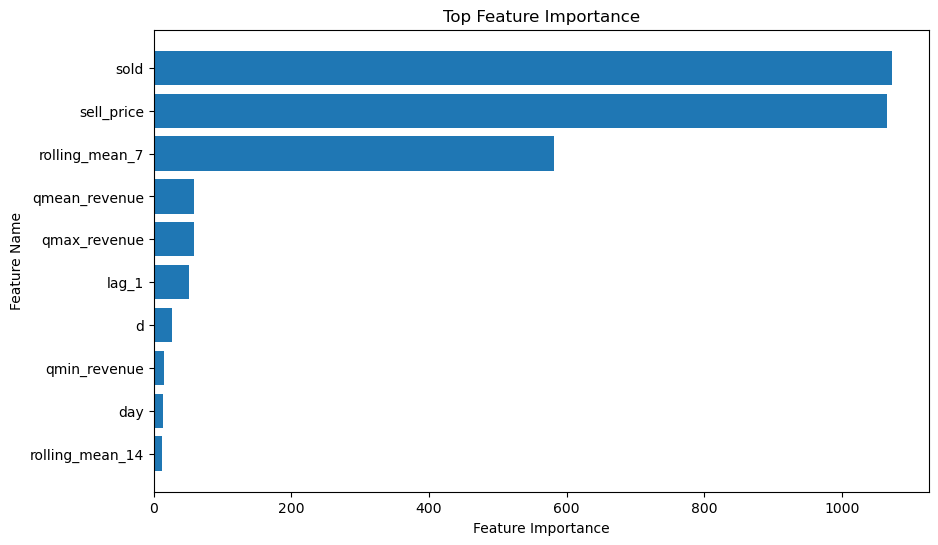

In [ ]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = clf.feature_importances_

# Get the names of the features
feature_names = x_train.columns

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 10 features
top_n = 10
print(f"Top {top_n} Features:")
print(feature_importance_df.head(top_n))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:top_n], feature_importance_df['Importance'][:top_n])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()


In [ ]:
import pickle
from sklearn.metrics import mean_squared_error

In [126]:
pickle.dump(clf, open('prediction_model.pkl', 'wb'))

In [127]:
prediction_model = pickle.load(open('prediction_model.pkl', 'rb'))

In [128]:
prediction_model.predict(x_test)

array([ 2.31578465,  0.00776066, -0.01260598, ...,  4.44512037,
        0.00536247,  0.00447499])

In [129]:
x_test

,item_id,store_id,day,year,month
94161,67,0,21,2011,6
388766,546,0,10,2012,9
239899,387,0,28,2012,1
673116,640,0,16,2013,11
293715,247,0,19,2012,4
...,...,...,...,...,...
87677,163,0,11,2011,6
321145,41,0,31,2012,5
722756,272,0,31,2014,1
208269,341,0,11,2011,12
